In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [3]:
from cov_3X2 import *
from lsst_utils import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
zs=lsst_source_tomo_bins()

ns0:  27.0


# Power Spectrum covariance

In [31]:
#setup parameters
lmax_cl=5000
lmin_cl=2
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False
Tri_cov=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

##  Test with 1 redshift bin

In [32]:
f_sky=0.35

In [33]:
z0=1 #1087
zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=30,use_window=True,unit_win=True,f_sky=f_sky)

cl dict done


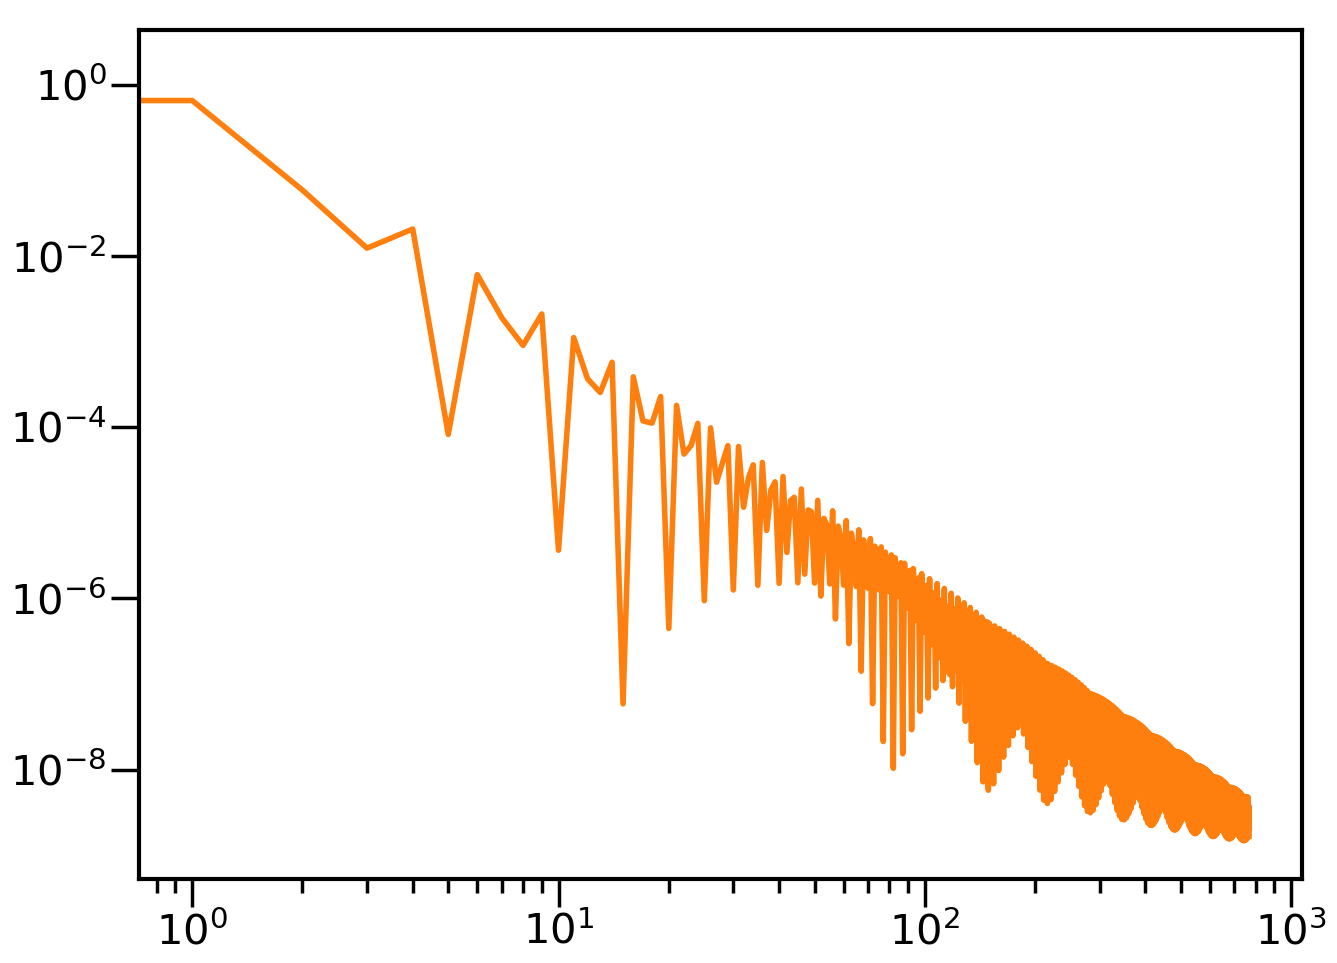

In [34]:
loglog(zs_bin1[0]['window_cl'])
loglog(hp.alm2cl(zs_bin1[0]['window_alm']))

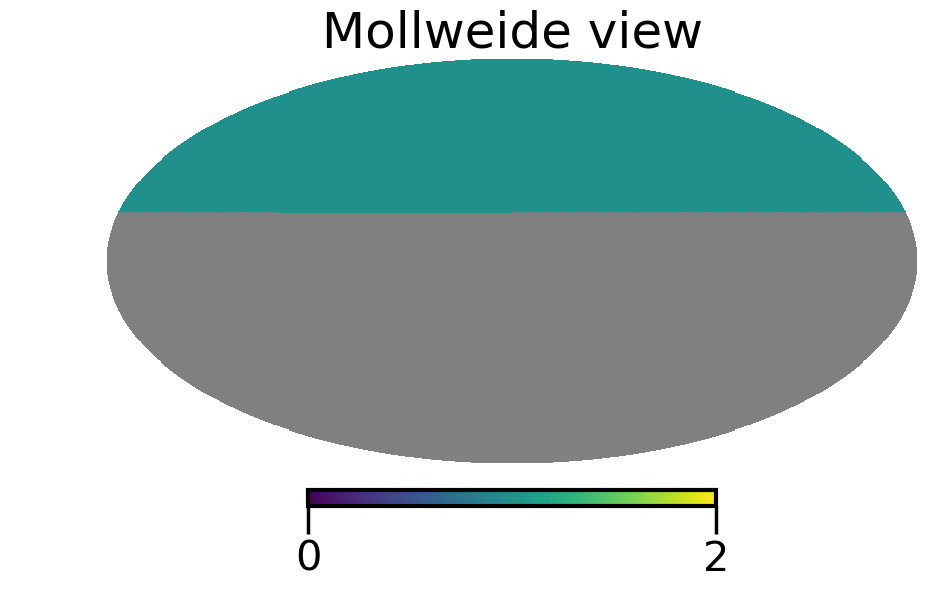

In [35]:
hp.mollview(zs_bin1[0]['window'])

In [36]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [37]:
# bin_cl=False
if not bin_cl:
    lb=l0
    l=l0

In [38]:
from astropy.cosmology import Planck15 as cosmo


In [39]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

In [40]:
use_window=False

In [41]:
power_spectra_kwargs={'pk_func':'baryon_pk'}

In [42]:
#use all ell
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,
                                       use_window=use_window,Tri_cov=Tri_cov,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       )
# kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,
#                                        use_window=True,Tri_cov=Tri_cov,store_win=True,
#                                        SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
#                                        )

In [43]:
#get compute graphs
%time cl0G=kappa0.cl_tomo() 
# %time cl0G_win=kappa_win.cl_tomo() 

cl dict done
CPU times: user 15.6 s, sys: 142 ms, total: 15.7 s
Wall time: 7.36 s


In [44]:
%time cl0=cl0G['stack'].compute()
# %time cl0_win=cl0G_win['stack'].compute()
# %time clB=clBG['stack'].compute()

0 True
True
2 True
True
4 True
True
CPU times: user 7.05 s, sys: 356 ms, total: 7.41 s
Wall time: 7.06 s


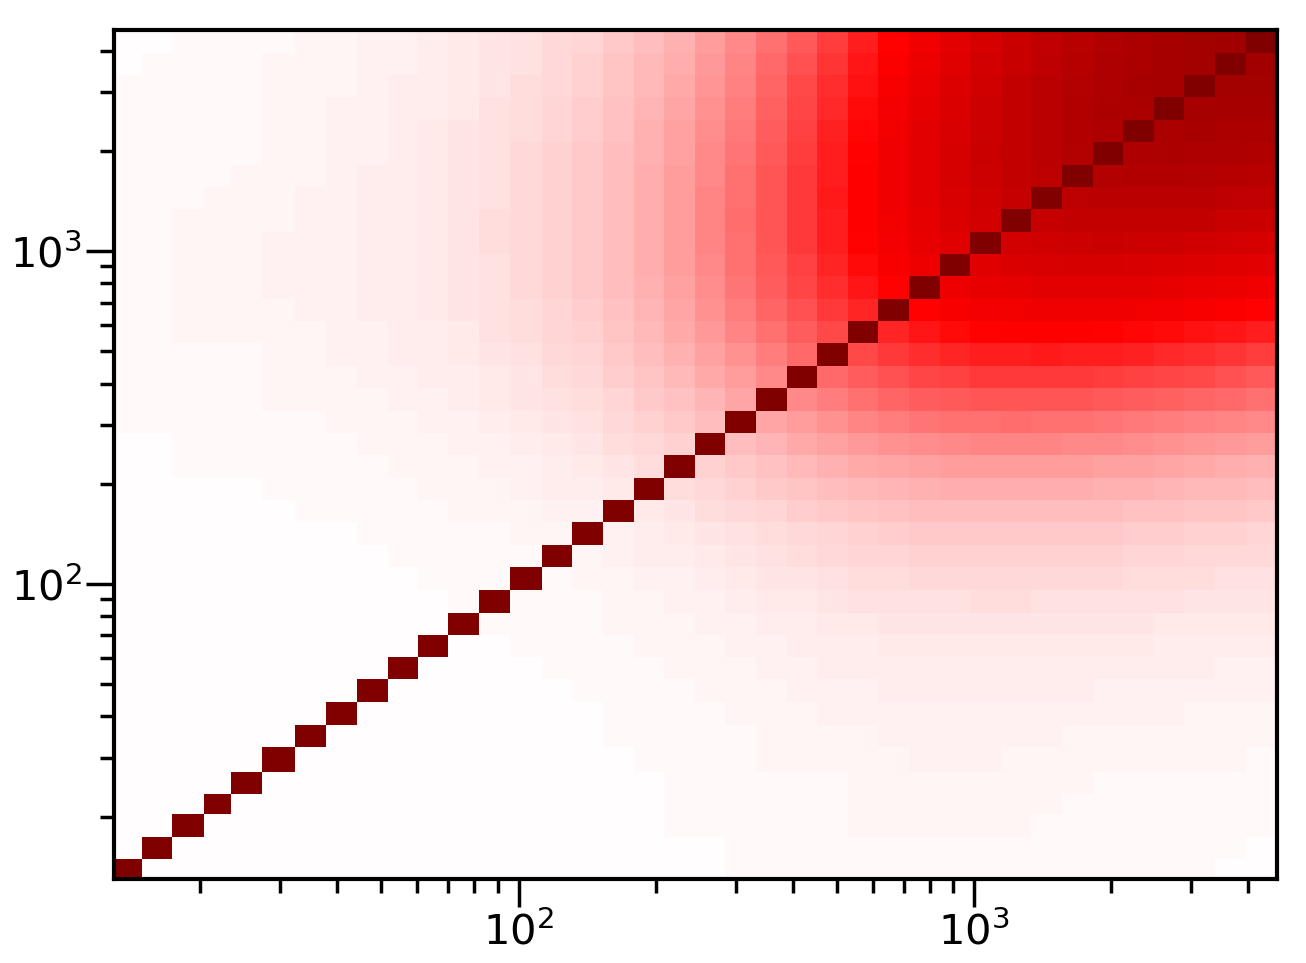

In [45]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [46]:
# compute signal/noise
cov_inv=np.linalg.inv(cl0['cov'])
SN2=(np.dot(cl0['cl_b'],np.dot(cov_inv,cl0['cl_b'])))
np.sqrt(SN2)

126.31530704988819

In [47]:
#again get Cl and cov, this time by referencing the particular bin
cl0={}
corr=('shear','shear')
%time cl0['cl0']=cl0G['cl'][corr][(0,0)].compute()
%time cl0['cl']=cl0G['cl_b'][corr].compute()
%time cl0['cov']=cl0G['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])

CPU times: user 10.7 ms, sys: 6.23 ms, total: 16.9 ms
Wall time: 15 ms
CPU times: user 13.7 ms, sys: 125 µs, total: 13.8 ms
Wall time: 12.7 ms
0 True
True
2 True
True
4 True
True
CPU times: user 7.12 s, sys: 385 ms, total: 7.51 s
Wall time: 7.16 s


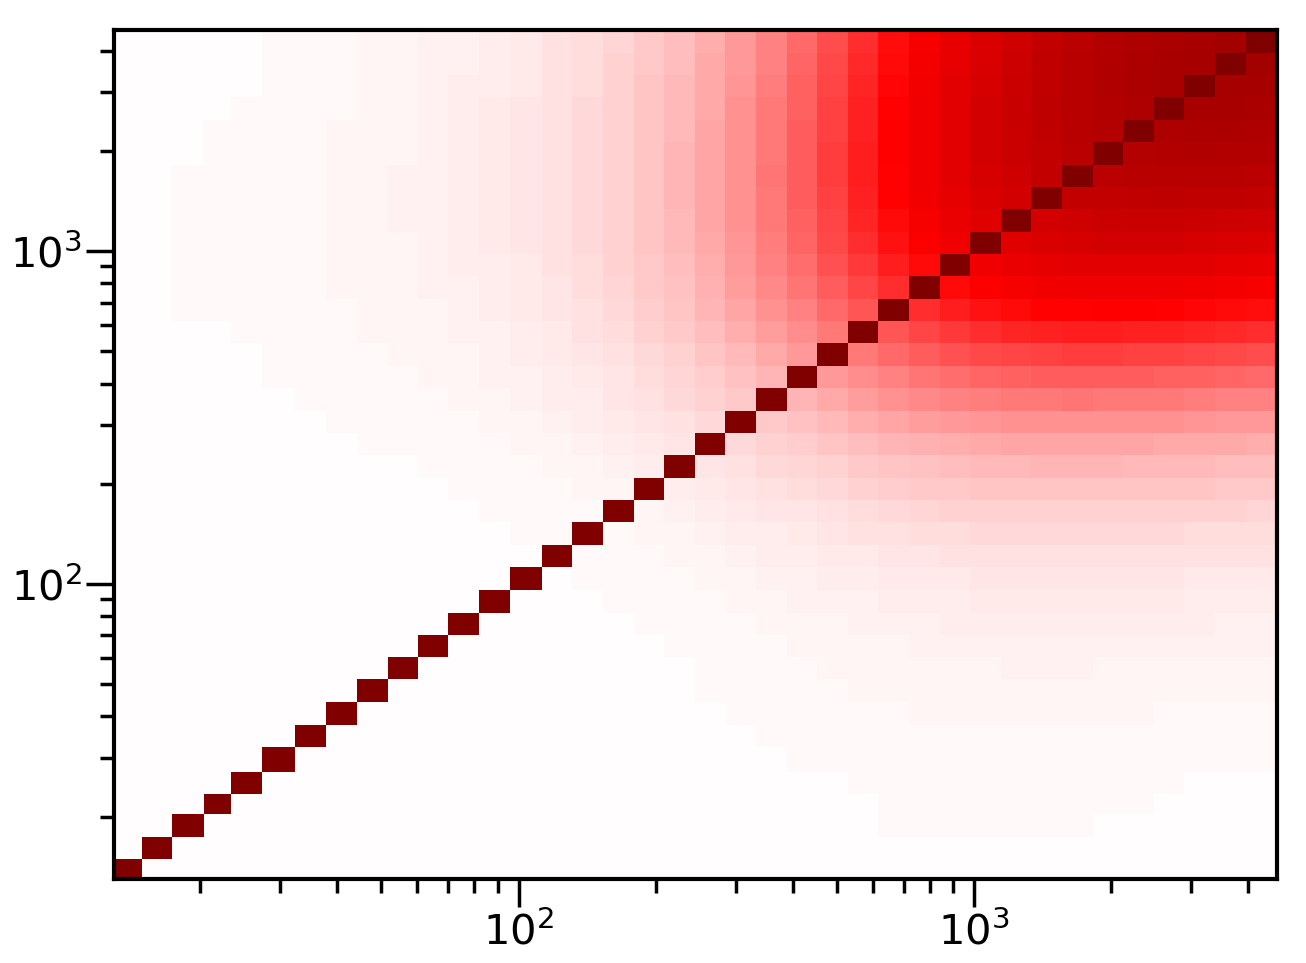

In [48]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['final_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

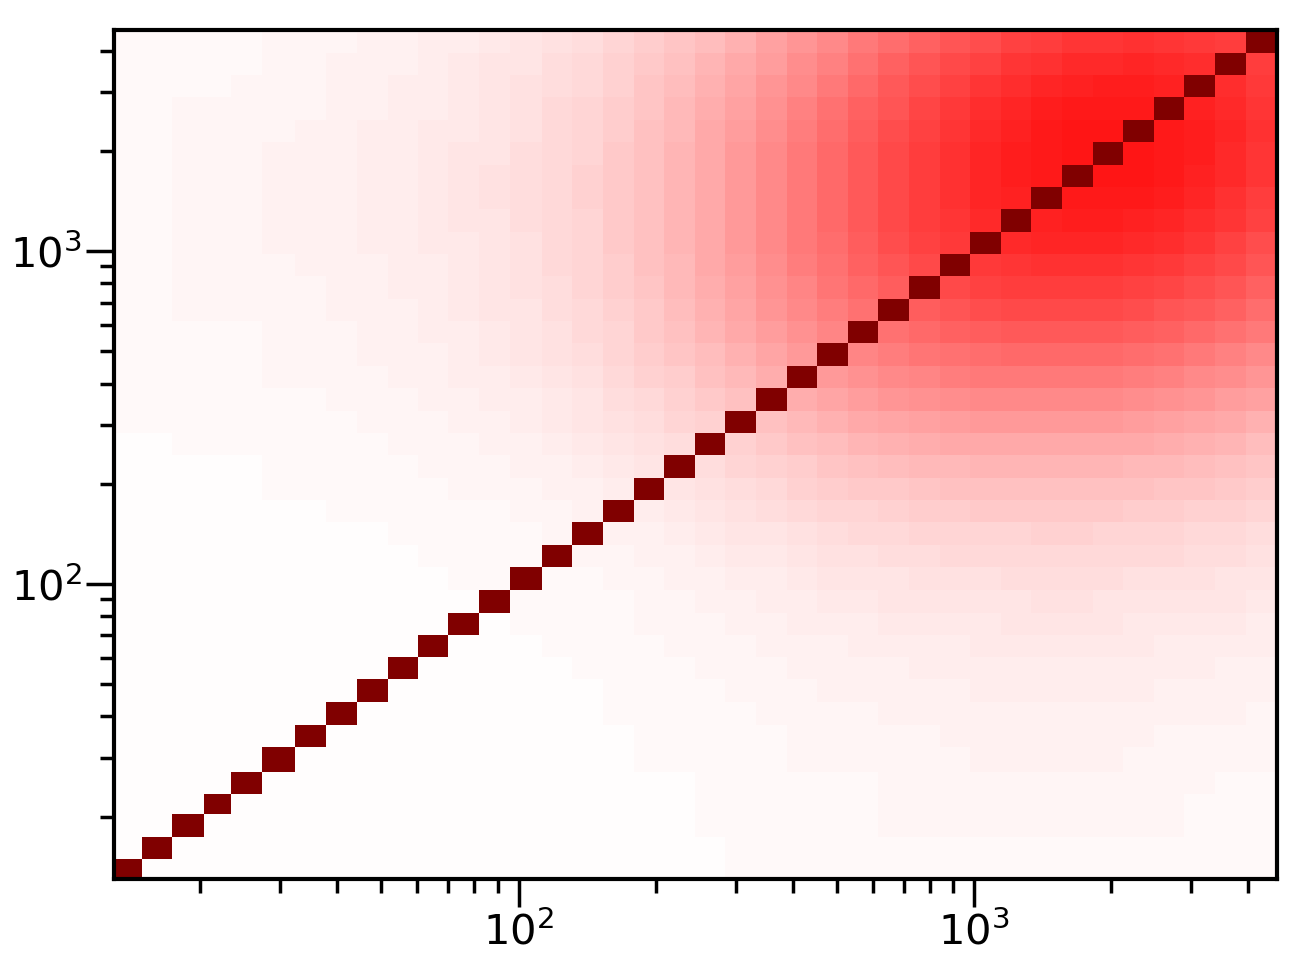

In [24]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['final_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

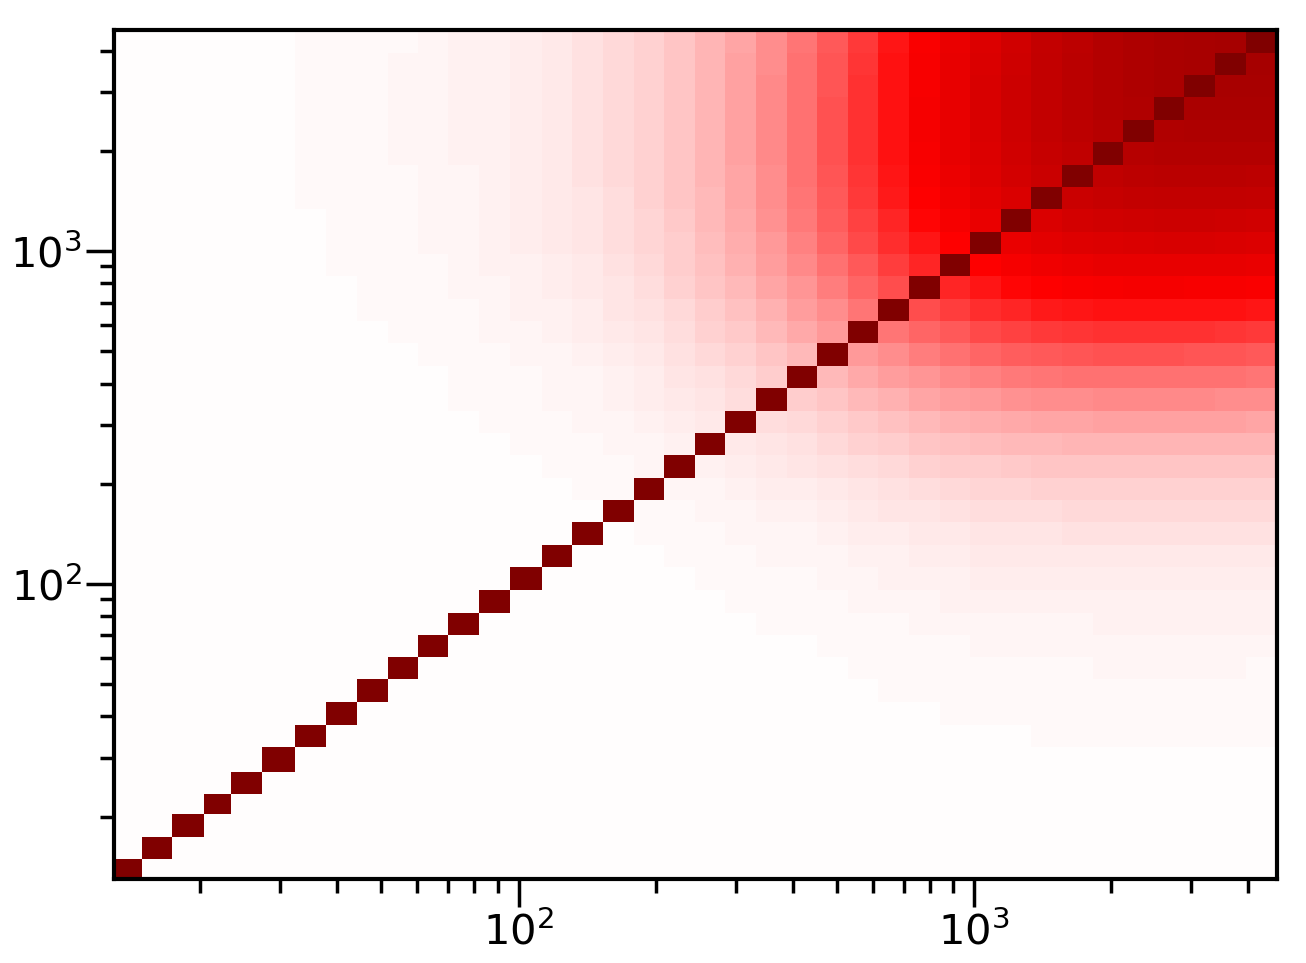

In [49]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['G_b']+cl0['cov']['Tri_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

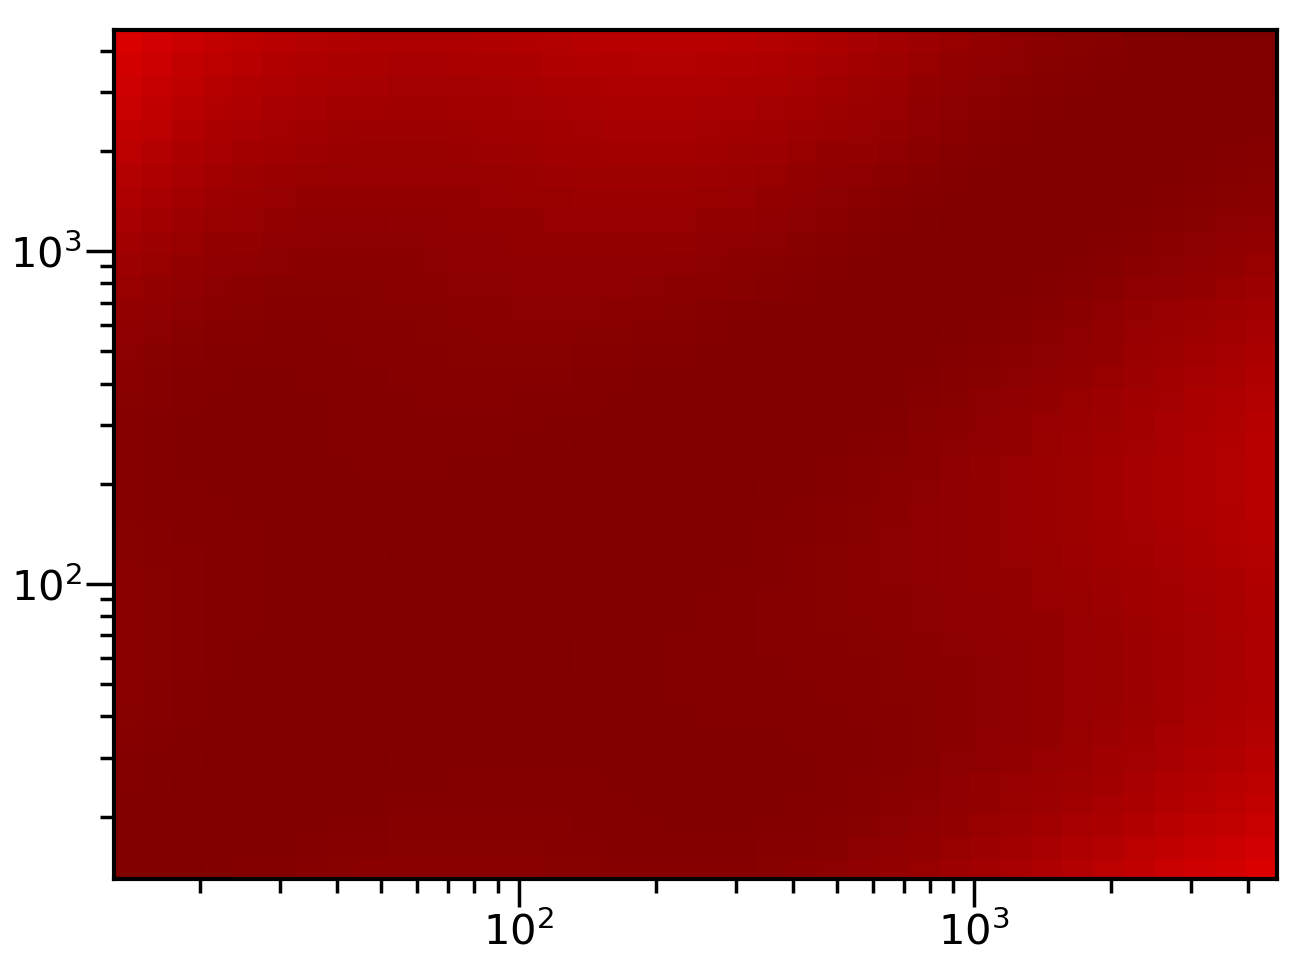

In [50]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['SSC_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

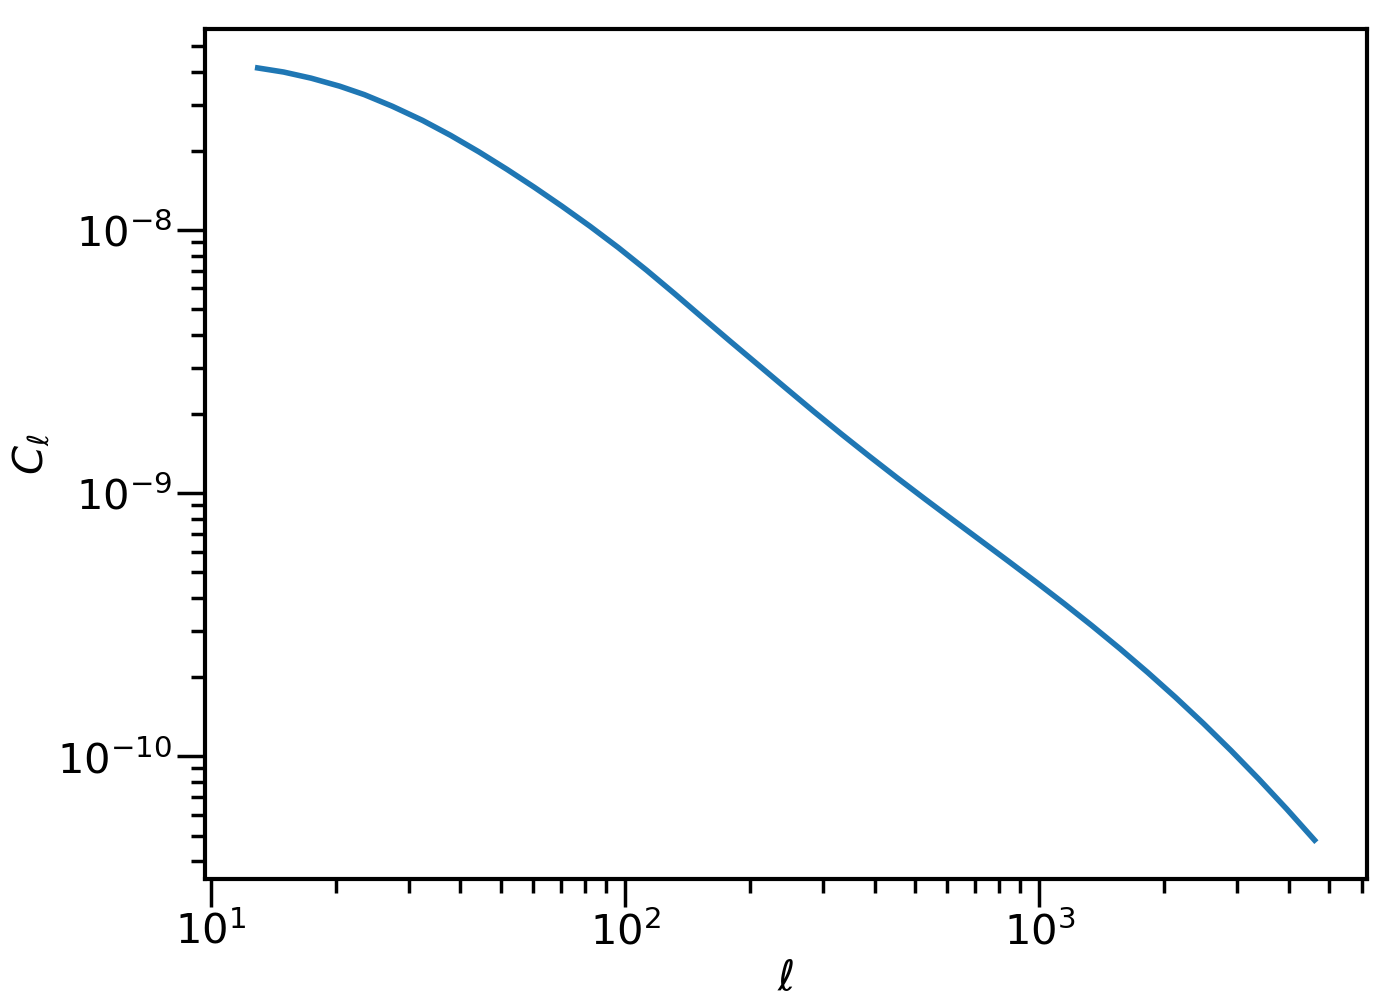

In [51]:
cl_t=cl0['cl'][(0,0)]
plot(lb,cl_t)
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')
show()

In [52]:
kappa0.cov_utils.Om_W

4.39822971502571

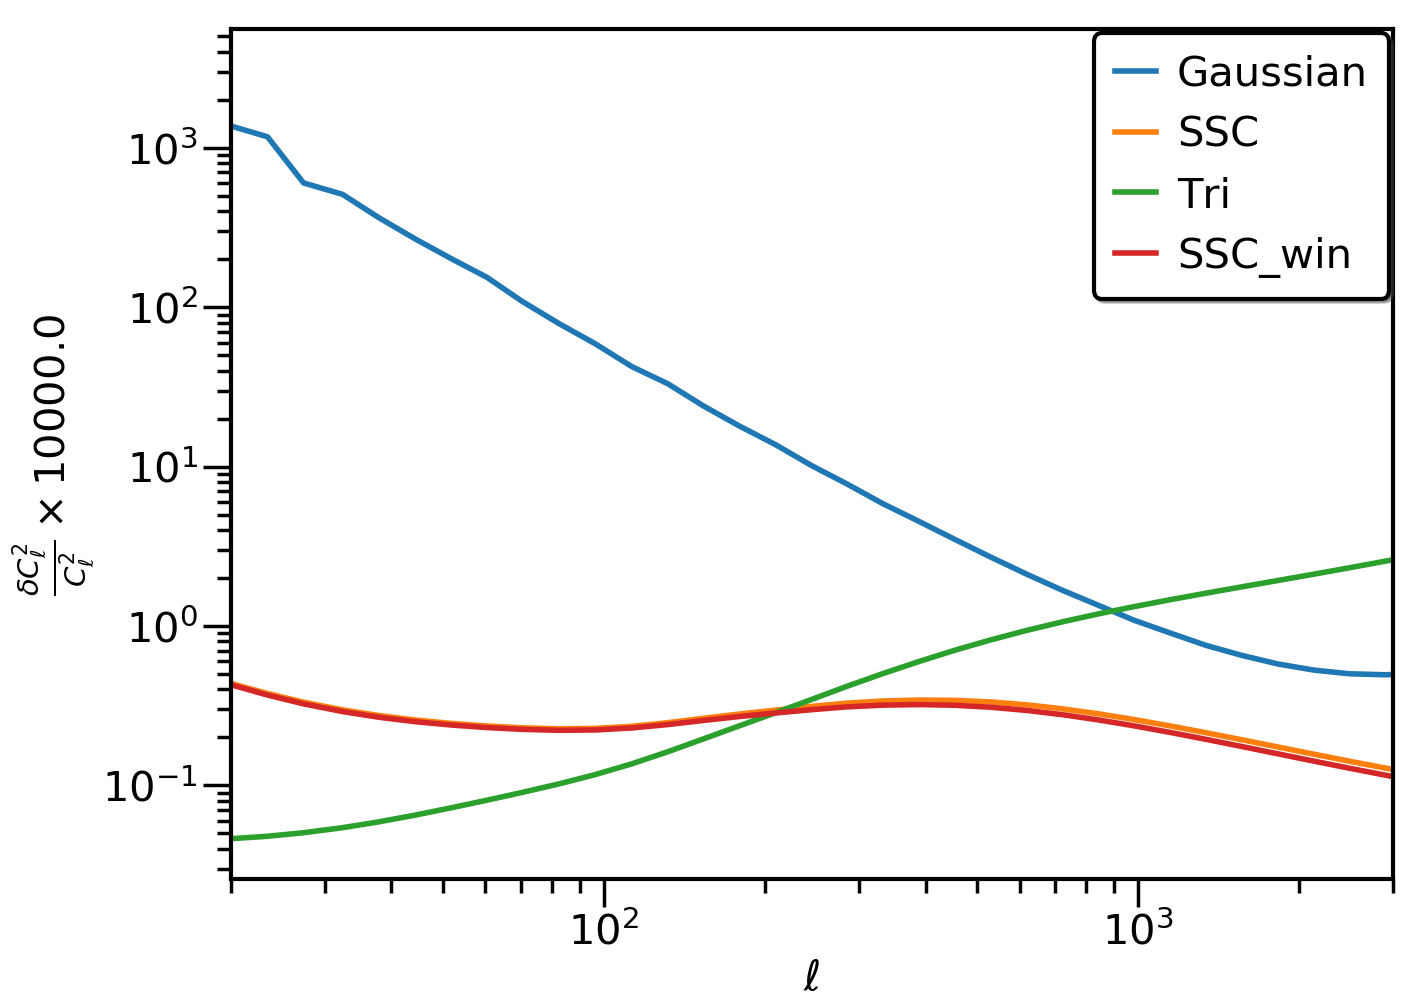

In [57]:
cov0=cl0['cov']#[(0,0,0,0)]
cov0_win=cl0_win['cov']#[(0,0,0,0)]

f=1e4
plot(lb,np.diag(cov0['G_b'])/cl_t**2*f,label='Gaussian')
plot(lb,np.diag(cov0['SSC_b'])/cl_t**2*f,label='SSC')
plot(lb,np.diag(cov0['Tri_b'])/cl_t**2*f,label='Tri')
plot(lb,np.diag(cov0_win['SSC_b'])/cl_t**2*f,label='SSC_win')
# plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(20,3000)
xlabel(r'$\ell$')
ylabel(r'$\frac{\delta C_\ell^2}{C_\ell^2}\times'+str(f)+'$')
legend()

(0.0001, 10)

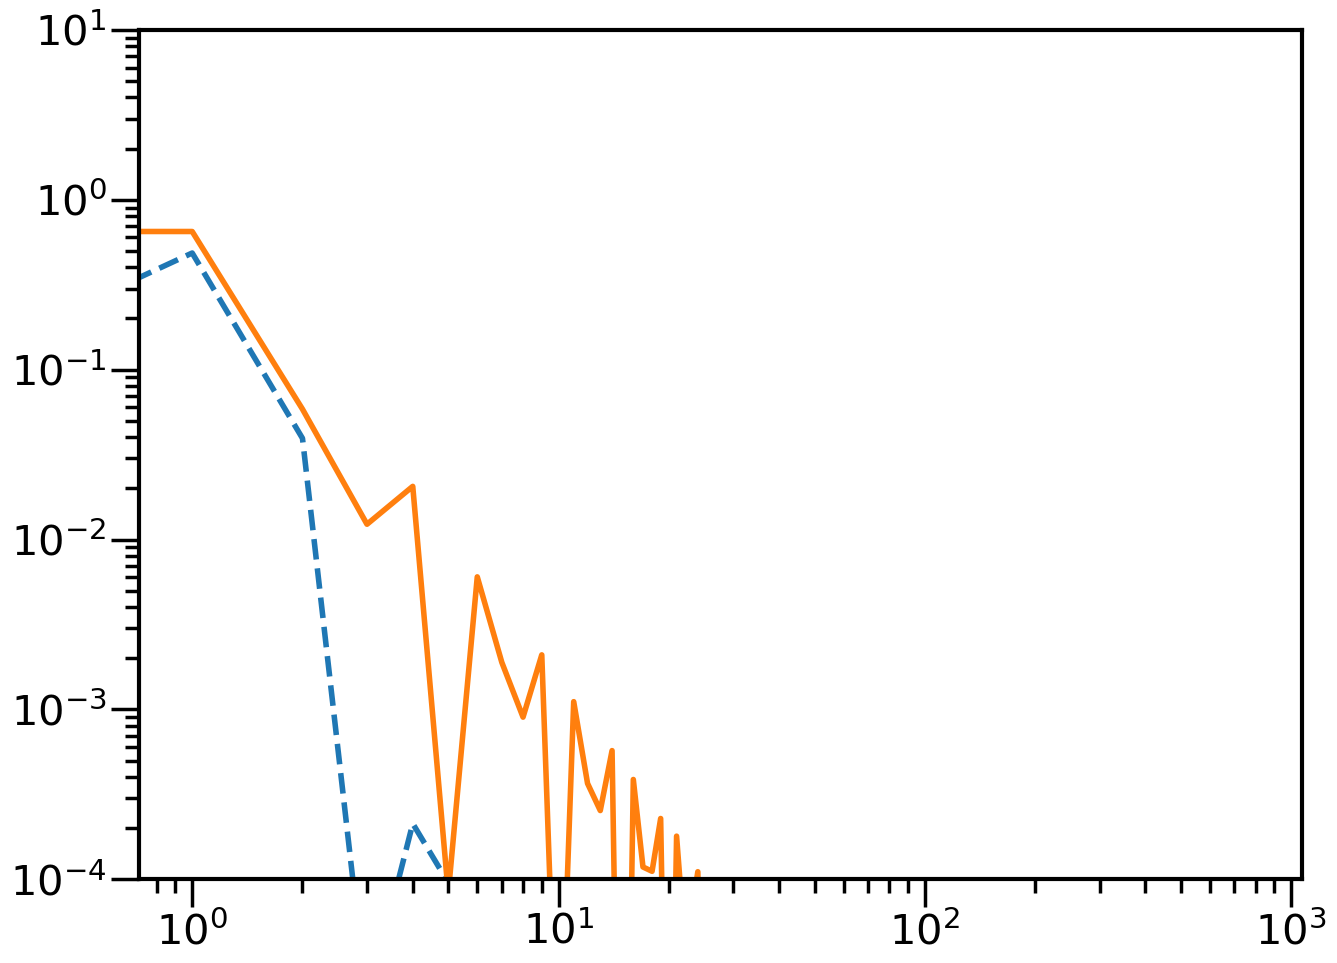

In [55]:
plot(kappa0.cov_utils.window_l,kappa0.cov_utils.Win**2,'--')
plot(hp.alm2cl(zs_bin1[0]['window_alm']))
loglog()
ylim(.0001,10)